In [1]:
%run metricas.ipynb 

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/awolfsdorf/.pyenv/versions/mettp3/bin/python (found version "3.7.5") 
-- Found PythonLibs: /home/awolfsdorf/.pyenv/versions/3.7.5/lib/libpython3.7m.a
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/awolfsdorf/Dropbox

In [2]:
df_original = pd.read_csv('../data/train.csv')
df = df_original.copy()
#df

SEGMENTACIÓN NUMÉRICA: \
la categoria seleccionada tiene que contener numeros, no palabras \
    n = cantidad de particiones \
    df es la matriz con toda la informacion \
    palabra es la columna por la cual segmentaremos

In [3]:
def segXcatNum(df, n , palabra):
    
    df = df[df['ciudad']=='Mérida'].dropna() #TODO sin esto no anda, averiguar por que
    
    tam = df.shape[0]
    linear_regressor = metnum.LinearRegression()
    
    
    df.sort_values("precio") #ordena de menor a mayor
    
    #tomo la columna de PALABRA y la de precios
    categoria = df[palabra].values
    precios = df['precio'].values
    vector = np.array([])
    for i in range(n):
        
        #tomo n bloques de longitud tam/n
        bloqueCategoria = categoria[int(i * tam/n) : int((i+1) * (tam/n))]
        bloquePrecios = precios[int(i * tam/n) : int((i+1) * tam/n)]
        
        #reshapeo
        bloqueCategoria = bloqueCategoria.reshape(len(bloqueCategoria),1)
        bloquePrecios = bloquePrecios.reshape(len(bloquePrecios),1)
        
        #fit y prediccion 
        linear_regressor.fit(bloqueCategoria, bloquePrecios)
        lin = linear_regressor.predict(bloqueCategoria)
        lin = lin.reshape(lin.shape[0])
        #reshapeo para poder meterlo en un array con el formato necesario
        vector = np.append(vector, lin)
        
    #df['prediction'] = vector ---- sirve para plotear cosas mas facil
    return vector





In [4]:
segmentado = segXcatNum(df, 5, 'metroscubiertos')
merida = df[df['ciudad']=='Mérida'].dropna() #TODO sin esto no anda, averiguar por que
original = merida['precio'].values
original = original.reshape(len(original))
print(original.shape, segmentado.shape)
print(
    "Correlacion: \n ",
coefCorrel(segmentado, original), "\n",
    "Determinacion: \n",
    coefDet(segmentado, original),  "\n",
    "RMSE: \n",
RMSE(segmentado, original), "\n",
    "RMSLE: \n", 
RMSLE(segmentado, original),

)

(518,) (518,)
Correlacion: 
  0.7421713193836197 
 Determinacion: 
 0.5508182673156228 
 RMSE: 
 676017.2546645574 
 RMSLE: 
 0.43092419953725103


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240000 non-null  int64  
 1   titulo                      234613 non-null  object 
 2   descripcion                 238381 non-null  object 
 3   tipodepropiedad             239954 non-null  object 
 4   direccion                   186928 non-null  object 
 5   ciudad                      239628 non-null  object 
 6   provincia                   239845 non-null  object 
 7   antiguedad                  196445 non-null  float64
 8   habitaciones                217529 non-null  float64
 9   garages                     202235 non-null  float64
 10  banos                       213779 non-null  float64
 11  metroscubiertos             222600 non-null  float64
 12  metrostotales               188533 non-null  float64
 13  idzona        

In [6]:
# Ideas de 

# Ideas de modelos
- Centros comerciales cercanos según antiguedad => centroscomercialescercanos = a x antiguedad + b
- Feature engeniere -> si esta cerca de una gran ciudad sube el precio.  -> para hacer Segmentacion
-                   -> Casa de gente con guita: gimnasio + piscina + tipopropiedad(casa, quinta, villa, alguno mas...) -> para hacer Segmentacion
-                   -> Ponerle pesos a algunas variables categoricas y sumarlas -> 
- Usar PCA para extraer componentes principales

In [7]:
df['tipodepropiedad'].value_counts()

Casa                             141717
Apartamento                       57341
Casa en condominio                19297
Terreno                            9945
Local Comercial                    3055
Oficina comercial                  1741
Bodega comercial                   1406
Edificio                           1396
Terreno comercial                  1326
Casa uso de suelo                   708
Quinta Vacacional                   395
Duplex                              343
Villa                               340
Inmuebles productivos urbanos       200
Rancho                              170
Local en centro comercial           165
Departamento Compartido             141
Otros                               134
Nave industrial                      76
Terreno industrial                   31
Huerta                               20
Lote                                  5
Hospedaje                             1
Garage                                1
Name: tipodepropiedad, dtype: int64

In [8]:
df[df['tipodepropiedad'] == 'Villa'].sort_values('precio')['precio']

95426       320000.0
7534        350000.0
8430        420000.0
234074      440000.0
149492      450000.0
             ...    
224173     9000000.0
130327     9000000.0
219406    10000000.0
60297     12000000.0
89786     12206700.0
Name: precio, Length: 340, dtype: float64

In [9]:
df[df['tipodepropiedad'] == 'Casa'].sort_values('precio')['precio']

184407      310000.0
30437       310000.0
189220      310000.0
133735      310000.0
213712      310000.0
             ...    
215495    12500000.0
92689     12500000.0
173245    12500000.0
232457    12515000.0
209858    12521000.0
Name: precio, Length: 141717, dtype: float64

In [10]:
def regresionPorSegmento(df, segment_column, features):
    predictions_df = pd.DataFrame()

    for segment in df[segment_column].unique():
        linear_regressor = metnum.LinearRegression()
        # Aquellos datos que no contengan la columna, no son tomados en cuenta
        df_segment = df[df[segment_column] == segment]

        A = df_segment[features].values
        precios_reales = df_segment['precio'].values
        
        linear_regressor.fit(A, precios_reales)
        precios_aproximados = linear_regressor.predict(A)
        precios_aproximados = precios_aproximados.reshape(precios_aproximados.shape[0])
        predictions_df[segment] = (linear_regressor, np.array(list(zip(precios_aproximados, precios_reales))))

    return predictions_df

In [61]:
# Modelo fruta
df = df_original.copy()
segment = 'tipodepropiedad'
features = ['banos', "habitaciones"]   #'metrostotales', 'metroscubiertos', "habitaciones", "banos", "antiguedad"]
df = df[df[segment].notna()]
for f in features:
    df = df[df[f].notna()]
df = df.sort_values(segment)

predictions = regresionPorSegmento(df, segment, features)



In [62]:
def print_heat_map(df, x_label, y_label, z_label):
    x_values = df[x_label].unique()
    y_values = df[y_label].unique()
    mat = np.ndarray((len(x_values), len(y_values)))
    i = 0
    for x in x_values:
        j = 0
        for y in y_values:
            val = df[df[x_label]==x][df[y_label]==y][z_label]
            val = np.mean(val) if len(val) != 0 else 0
            mat[i, j] = val
            j+=1
        i+=1
    plt.imshow(mat, cmap='hot')

/home/awolfsdorf/.pyenv/versions/3.7.5/envs/mettp3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/awolfsdorf/.pyenv/versions/3.7.5/envs/mettp3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


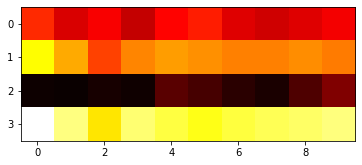

In [63]:
import seaborn as sns

# sns.scatterplot(data=df, x='metroscubiertos', y='precio')

df_new = df.copy()
df_new["precio_aproximado"] = np.nan
for s in df_new[segment].unique():
    df_new['precio_aproximado'][df_new[segment]==s] = predictions.loc[1, s][:,0]
# g = sns.FacetGrid(df_new, col=segment, col_wrap=5, height=4)
# g.map(plt.scatter, "metrostotales", "precio", alpha=0.3)
# g.map(plt.plot, "metroscubiertos", "precio_aproximado", color="red")
df_new.astype({"precio_aproximado": int})
print_heat_map(df_new, features[0], features[1], "precio_aproximado")